# Classification Systems

In this practical, you are asked to compare the prediction error of:

 1. The Naive Bayes Classifier
 2. LDA
 3. QDA
 4. Nearest Shrunken Centroids Classifier

On the Breast Cancer dataset provided in the previous notebooks, and the Prostate cancer dataset attached. The details about this last dataset are found in the reference:

Singh, D., Febbo, P., Ross, K., Jackson, D., Manola, J., Ladd, C., Tamayo, P., Renshaw, A., D’Amico, A., Richie, J., Lander, E., Loda, M., Kantoff, P., Golub, T., & Sellers, W. (2002). Gene expression correlates of clinical prostate cancer behavior. Cancer Cell, 1, 203–209.

This dataset is in CSV format and the last column contains the class label. The task of interest is to discriminate between normal and tumor tissue samples.

Importantly:

Use a random split of 2 / 3 of the data for training and 1 / 3 for testing each classifier. 
Any hyper-parameter of each method should be tuned using a grid-search guided by an inner cross-validation procedure that uses only training data.
To reduce the variance of the estimates, report average error results over 20 different partitions of the data into training and testing as described above.
Submit a notebook showing the code and the results obtained. Give some comments about the results and respond to these questions:

What method performs best on each dataset?
What method is more flexible?
What method is more robust to over-fitting?


In [100]:
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib as mpl
from matplotlib import colors
import seaborn as sns; sns.set()
import scipy.stats as stats
import scipy as sp
from scipy import linalg
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import NearestCentroid
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, make_scorer, confusion_matrix

## Methods

In [160]:
def create_datasets_from_file(data_file, header, random_state, label_pos, 
                              label_value, features_ini, features_fin=None):
    """Create training and test sets from file

        Args:
            data_file (string): Name of the data file (csv) of samples a features
            header (string): None or position of the header (pandas read_csv parameter)
            random_state (int): Seed for the random split (as needed for sklearn train_test_split)
            label_pos (int): Column of the labels in data_file
            label_value (int): Value of the label to asign internal '1' value
            features_ini (int): First column of features in data_file
            features_fin (int): Last column + 1 of features in data_file. If None, last column of file.

        Returns:
            (np.array): train set scaled
            (np.array): test set scaled
            (np.array): class labels for the train set
            (np.array): class labels for the test set
                
    """
    data = pd.read_csv(data_file, header = header)
    if features_fin == None:
        X = data.values[ :, features_ini:].astype(np.float)
    else:
        X = data.values[ :, features_ini:features_fin].astype(np.float)
    y = (data.values[ :, label_pos ] == label_value).astype(np.int)
    # Split dataset between training and test
    x_train, x_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=1.0/3, random_state=random_state)
    # Data standardization
    scaler = preprocessing.StandardScaler().fit(x_train)
    x_train_scaled = scaler.transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    # Check standardization
    for i in range (1, np.size(x_train_scaled,1)):
        assert round(np.var(x_train_scaled[:,0]),3) == round(np.var(x_train_scaled[:,i]),3),\
        "Warning: revise data standardization"

    return x_train_scaled, x_test_scaled, y_train, y_test

def prediction_accuracy(x_train, x_test, y_train, y_test, method_func, method_param, param_value):
    """Estimate parameter given training and test sets:
        Args:
            x_train (np.array): train set
            x_test (np.array): test set
            y_train (np.array): class labels for the train set
            y_test (np.array): class labels for the test set
            method_func (string) : name of the learning method
            param (string): name of learning method parameter
            param_value (float): value of parameter to try
        Returns:
            float: best parameter value to use in prediction
                
    """
    if method_param != "" :
        params = {method_param : param_value}
    else:
        params ={}
    method = globals()[method_func](**params)
  
    # Training
    method.fit(x_train, y_train)

    # Prediction
    y_pred = method.predict(x_test)
    conf = confusion_matrix(y_test, y_pred)
    TN = conf[0][0]
    TP = conf[1][1]
    FP = conf[0][1]
    FN = conf[1][0]
    print(conf)
    print('Predicion accuracy is: %f' % ((TP + TN) / (TN + TP + FP + FN)))
    print('True postive rate is: %f' % (TP / (TP + FN)))
    print('True negative rate is: %f\n' % (TN / (TN + FP)))

def estimate_parameter(x_train, x_test, y_train, y_test, method_func, param, param_values):
    """Estimate parameter given training and test sets:
        Args:
            x_train (np.array): train set
            x_test (np.array): test set
            y_train (np.array): class labels for the train set
            y_test (np.array): class labels for the test set
            method_func (string) : name of the learning method
            param (string): name of learning method parameter
            param_values (list of float): list of parameter values to try
        Returns:
            (float): best parameter value to use in prediction
                
    """
    # Pipeline for estimate the regularization parameter
    pipeline = Pipeline([ ('method', globals()[method_func]()) ])

    # Construct the grid the hyperparameter candidate shronk theshold
    param_grid = { 'method__' + param : param_values }

    # Evaluating 
    skfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=0)
    gridcv = GridSearchCV(pipeline, cv=skfold, n_jobs=1, param_grid=param_grid, \
        scoring=make_scorer(accuracy_score))
    result = gridcv.fit(x_train, y_train)

    # Accuracies
    accuracies = gridcv.cv_results_['mean_test_score']
    std_accuracies = gridcv.cv_results_['std_test_score']

    test_accuracies = np.ones(len(param_values))
   
    for i in range(len(param_values)):
        method_params = {param : param_values[ i ]}
        method = globals()[method_func](**method_params)
        method.fit(x_train, y_train)
        test_accuracies[ i ] = accuracy_score(method.predict(x_test), y_test)
    
    max_test_accuracy = max(test_accuracies)
    
    # Obtain best_param_value as max 
    best_param_value = 0
    best_train_accuracy = 0
    for i in range(len(param_values)):
        if test_accuracies[ i ] == max_test_accuracy:
            if accuracies[i] > best_train_accuracy:
                best_train_accuracy = accuracies[i]
                best_param_value = param_values[i]
                              
    # Plot
    plt.figure(figsize=(15, 10))
    line1, = plt.plot(param_values, accuracies, 'o-', color="g")
    line2, = plt.plot(param_values, test_accuracies, 'x-', color="r")
    plt.fill_between(param_values, accuracies - std_accuracies / np.sqrt(10), \
        accuracies + std_accuracies / np.sqrt(10), alpha=0.1, color="g")
    plt.grid()
    plt.title("Different hyper-parameter " + param + " values for " + method_func)
    plt.xlabel('Hyper-parameter')
    plt.xticks(np.round(np.array(param_values), 2))
    plt.ylabel('Classification Accuracy')
    plt.ylim((min(accuracies) - 0.1, max(accuracies) + 0.1))

    plt.xlim((min(param_values), max(param_values)))
    legend_handles = [ mlines.Line2D([], [], color='g', marker='o', \
                              markersize=15, label='CV-estimate'), \
                    mlines.Line2D([], [], color='r', marker='x', \
                              markersize=15, label='Test set estimate')]
    plt.legend(handles=legend_handles, loc = 3)
    plt.show()
    
    print("Best param value:", best_param_value)
    return best_param_value
    
def learn_dataset(data_file, header, random_state, label_pos, 
                  label_value, features_ini, features_fin=None):
    """Learn data sets from file, methods:
            1. The Naive Bayes Classifier
            2. LDA
            3. QDA
            4. Nearest Shrunken Centroids Classifier
        Args:
            data_file (string): Name of the data file (csv) of samples a features
            header (string): None or position of the header (pandas read_csv parameter)
            random_state (int): Seed for the random split of sets (as needed for sklearn train_test_split)
            label_pos (int): Column of the labels in data_file
            label_value (int): Value of the label to asign internal '1' value
            features_ini (int): First column of features in data_file
            features_fin (int): Last column + 1 of features in data_file. If None, last column of file
                
    """
    X_train_scaled, X_test_scaled, y_train, y_test = \
        create_datasets_from_file(data_file, header, random_state, 
                                  label_pos, label_value, features_ini, features_fin=None)
    print(X_train_scaled.shape)

    # Naive Bayes accuracy
    prediction_accuracy(X_train_scaled, X_test_scaled, y_train, y_test, "GaussianNB", "", "")

    # LDA accuracy
    prediction_accuracy(X_train_scaled, X_test_scaled, y_train, y_test, "LinearDiscriminantAnalysis", "", "")

    # QDA estimate reg parameter
    param_values = np.linspace(0, 1, 10).tolist()
    best_param_value = estimate_parameter(X_train_scaled, X_test_scaled, y_train, y_test,\
                       "QuadraticDiscriminantAnalysis", "reg_param", param_values)
    # QDA accuracy
    # Best parameter reg value according CV estimate
    prediction_accuracy(X_train_scaled, X_test_scaled, y_train, y_test, \
                        "QuadraticDiscriminantAnalysis", "reg_param", best_param_value)

    # Centroids
    # Best parameter shrink_threshold value according CV estimate
    param_values = np.linspace(0, 8, 20).tolist()
    best_param_value = estimate_parameter(X_train_scaled, X_test_scaled, y_train, y_test,\
                       "NearestCentroid", "shrink_threshold", param_values)
    # Centroids accuracy
    prediction_accuracy(X_train_scaled, X_test_scaled, y_train, y_test, "NearestCentroid", "shrink_threshold", best_param_value)

## Breast cancer

(379, 30)
[[ 61   5]
 [  7 117]]
Predicion accuracy is: 0.936842
True postive rate is: 0.943548
True negative rate is: 0.924242

[[ 60   6]
 [  1 123]]
Predicion accuracy is: 0.963158
True postive rate is: 0.991935
True negative rate is: 0.909091



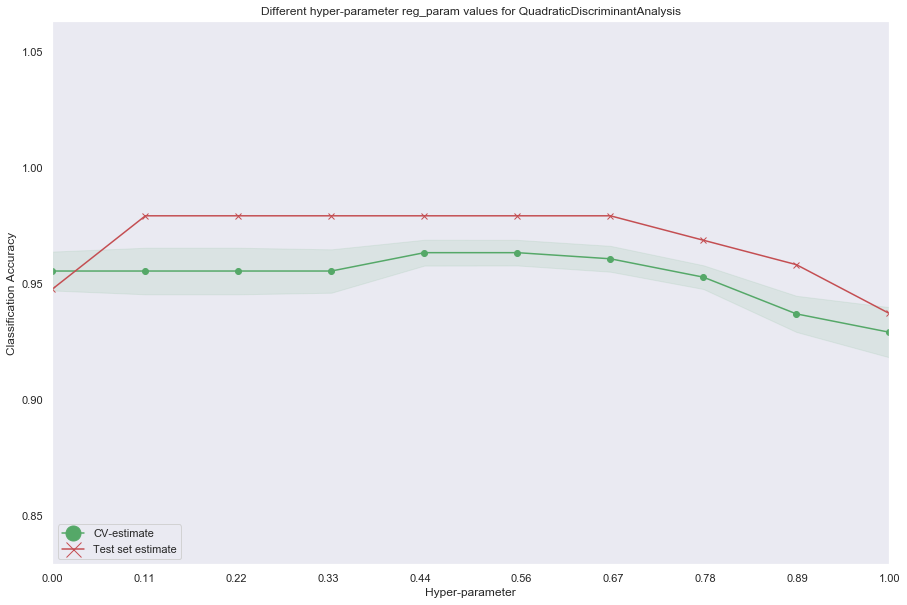

Best param value: 0.4444444444444444
[[ 62   4]
 [  0 124]]
Predicion accuracy is: 0.978947
True postive rate is: 1.000000
True negative rate is: 0.939394



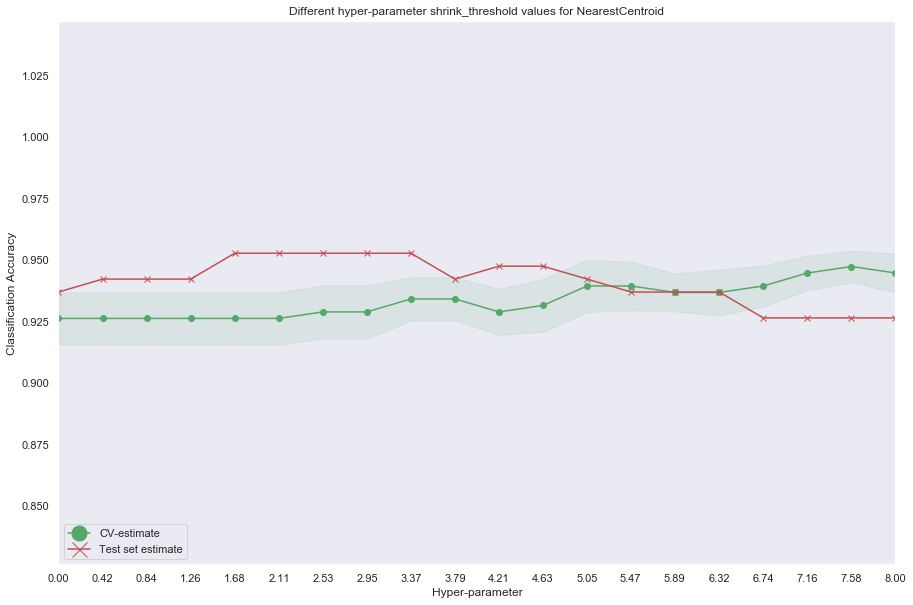

Best param value: 3.3684210526315788
[[ 60   6]
 [  3 121]]
Predicion accuracy is: 0.952632
True postive rate is: 0.975806
True negative rate is: 0.909091



In [163]:
# Breast Cancer
data_file = './data/wdbc.csv'
learn_dataset(data_file, None, 1, 1, "B", 2)

## Prostate cancer

(68, 12626)
[[16  0]
 [ 0 18]]
Predicion accuracy is: 1.000000
True postive rate is: 1.000000
True negative rate is: 1.000000

[[15  1]
 [ 4 14]]
Predicion accuracy is: 0.852941
True postive rate is: 0.777778
True negative rate is: 0.937500



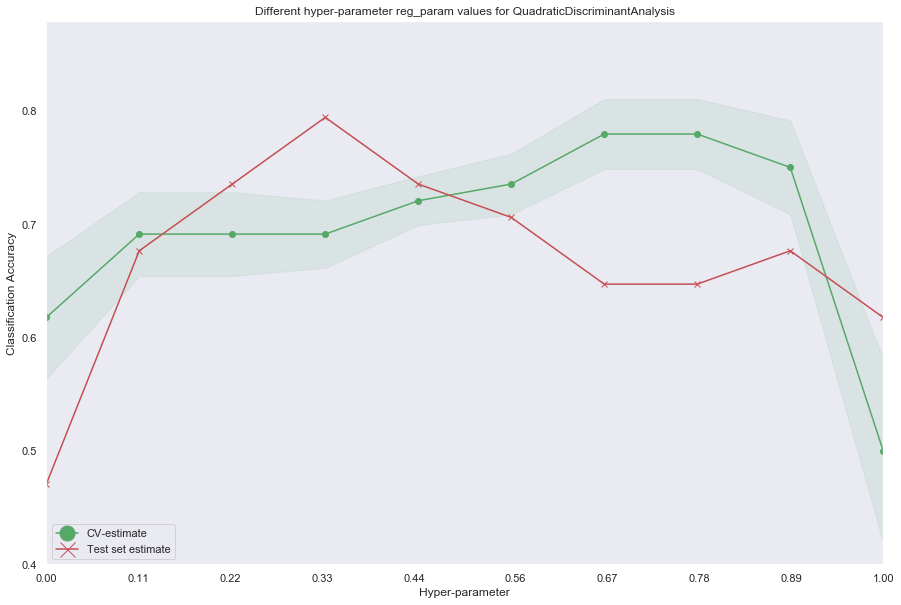

Best param value: 0.3333333333333333
[[13  3]
 [ 4 14]]
Predicion accuracy is: 0.794118
True postive rate is: 0.777778
True negative rate is: 0.812500



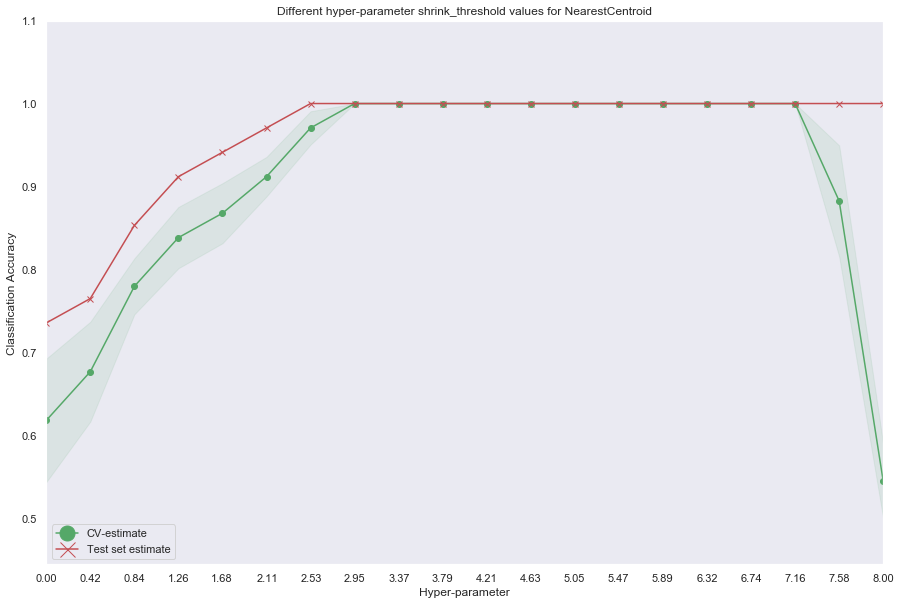

Best param value: 2.9473684210526314
[[16  0]
 [ 0 18]]
Predicion accuracy is: 1.000000
True postive rate is: 1.000000
True negative rate is: 1.000000



In [164]:
# Prostate Cancer
data_file = './data/prostate.csv'
learn_dataset(data_file, 0, 1, -1, 1, 0, -1)

# Outputs

In [166]:
%%bash
jupyter nbconvert --to=latex --template=~/report.tplx classification_systems.ipynb 1> /dev/null
pdflatex -shell-escape classification_systems 1> /dev/null
jupyter nbconvert --to html_with_toclenvs classification_systems.ipynb 1> /dev/null

[NbConvertApp] Converting notebook classification_systems.ipynb to latex
[NbConvertApp] Support files will be in classification_systems_files/
[NbConvertApp] Making directory classification_systems_files
[NbConvertApp] Making directory classification_systems_files
[NbConvertApp] Making directory classification_systems_files
[NbConvertApp] Making directory classification_systems_files
[NbConvertApp] Writing 39449 bytes to classification_systems.tex
[NbConvertApp] Converting notebook classification_systems.ipynb to html_with_toclenvs
[NbConvertApp] Writing 578715 bytes to classification_systems.html
